# Onelake SQL Support test
Unified notebook supporting multiple engines: chdb, duckdb, lakesail

In [1]:
# Parameters - modify these to configure the benchmark
SF         =  6             
engine     = 'datafusion'      
ws         = 'tpch'          # Workspace name
lh         = 'raw'           # Lakehouse name
base_path  = f'abfss://{ws}@onelake.dfs.fabric.microsoft.com/{lh}.Lakehouse'
results    = base_path +'/Tables/dbo/resultss'

In [2]:
# Save parameters to file for use after Python restart
import json
with open('/tmp/tpch_params.json', 'w') as f:
    json.dump({'SF': SF, 'engine': engine, 'base_path': base_path, 'results': results,'ws':ws,'lh':lh}, f)

In [3]:
!pip install -q deltalake==1.2.1 # latest version supported by datafusion 51
if engine == 'duckdb':
    !pip install duckdb  --upgrade
elif engine == 'polars':
    !pip install -q polars --upgrade
    !pip install -q deltalake --upgrade
elif engine == 'lakesail':
    !pip install -q pyspark-client --upgrade
    !pip install -q pysail
elif engine in ('datafusion'):
    !pip install -q datafusion
notebookutils.session.restartPython()

sys.exit called with value 0. The interpreter will be restarted.


In [4]:
# Load parameters from file after restart
import json
with open('/tmp/tpch_params.json', 'r') as f:
    params = json.load(f)
SF         = params['SF']
engine     = params['engine']
base_path  = params['base_path']
results    = params['results']
ws         = params['ws']
lh         = params['lh']
schema = f'CH{SF:04d}'
tpch_tables = ['nation','region','customer','supplier','lineitem','orders','partsupp','part']

In [5]:
import pandas  as pd
import pyarrow as pa
from  datetime import datetime
from  deltalake import write_deltalake , convert_to_deltalake, DeltaTable
from  psutil import *
import time
import pathlib
import tempfile
import subprocess
from pathlib import Path

if engine == 'duckdb':
    import duckdb
if engine == 'polars':
    import polars as pl
if engine == 'lakesail':
    from pysail.spark import SparkConnectServer
    from pyspark.sql import SparkSession
if engine in ('datafusion'):
    from   datafusion         import SessionContext

# Generate Data

In [6]:
%%time
# ABFSS target path
ABFSS_BASE_PATH = f"Tables/{schema}"

# Parts config (same as before)
lineitem_parts = max(2, int(200 * (SF / 1000)))
orders_parts   = max(2, int(140 * (SF / 1000)))
partsupp_parts = max(1, int(80 * (SF / 1000)))
part_parts     = max(1, int(12 * (SF / 1000)))
customer_parts = max(1, int(20 * (SF / 1000)))

TABLES_PARTS = {
    "lineitem": lineitem_parts,
    "orders": orders_parts,
    "partsupp": partsupp_parts,
    "part": part_parts,
    "customer": customer_parts,
    "nation": 1,
    "region": 1,
    "supplier": 1,
}

# Check if data already exists
from deltalake import DeltaTable, convert_to_deltalake
check_path = f"{base_path}/{ABFSS_BASE_PATH}/supplier"

if not DeltaTable.is_deltatable(check_path):
    !pip install -q tpchgen-cli
    !pip install obstore --upgrade
    import obstore as obs
    from obstore.store import AzureStore
    store = AzureStore.from_url(base_path)
    print(f'Generating TPC-H SF={SF} to {base_path}/{ABFSS_BASE_PATH}')
    
    with tempfile.TemporaryDirectory() as temp_dir:
        temp_path = Path(temp_dir)
        
        for table_name, total_parts in TABLES_PARTS.items():
            print(f"\n--- {table_name} ({total_parts} parts) ---")
            
            for part_num in range(1, total_parts + 1):
                # Generate one part at a time
                subprocess.run([
                    "tpchgen-cli",
                    "-s", str(SF),
                    "--tables", table_name,
                    "--output-dir", str(temp_path),
                    "--parts", str(total_parts),
                    "--part", str(part_num),
                    "--format", "parquet",
                    "--parquet-row-group-bytes", "268435456"
                ], check=True)
                
                # Find and upload the generated file
                table_dir = temp_path / table_name
                for parquet_file in table_dir.glob("*.parquet"):
                    remote_path = f"{ABFSS_BASE_PATH}/{table_name}/{parquet_file.name}"
                    obs.put(store, remote_path, parquet_file)
                    print(f"  Part {part_num}/{total_parts}: uploaded {parquet_file.name}")
                    parquet_file.unlink()  # Delete local file immediately
    
    # Convert to Delta
    print("\nConverting to Delta Lake...")
    for tbl in tpch_tables:
        convert_to_deltalake(f"{base_path}/{ABFSS_BASE_PATH}/{tbl}")
    
    print("Done!")
else:
    print('Data already exists')

Data already exists
CPU times: user 7.63 ms, sys: 4.69 ms, total: 12.3 ms
Wall time: 892 ms


In [7]:
core = cpu_count()
vCPU = str(core) + " vCPU"
mem = round(virtual_memory().total / (1024 * 1024 * 1024), 0)
core

2

# SQL Query

In [8]:
sql = (f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;



WITH cheapest_part AS (
    SELECT
        MIN(ps.ps_supplycost) AS cp_lowest,
        p.p_partkey AS cp_partkey
    FROM part p
    JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
    JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
    JOIN nation n ON s.s_nationkey = n.n_nationkey
    JOIN region r ON n.n_regionkey = r.r_regionkey
    WHERE r.r_name = 'EUROPE'
    GROUP BY p.p_partkey
)
SELECT
    s.s_acctbal,
    s.s_name,
    n.n_name,
    p.p_partkey,
    p.p_mfgr,
    s.s_address,
    s.s_phone,
    s.s_comment
FROM part p
JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
JOIN region r ON n.n_regionkey = r.r_regionkey
JOIN cheapest_part cp ON ps.ps_supplycost = cp.cp_lowest AND cp.cp_partkey = p.p_partkey
WHERE p.p_size = 15
  AND p.p_type LIKE '%BRASS'
  AND r.r_name = 'EUROPE'
ORDER BY s.s_acctbal DESC,
         n.n_name,
         s.s_name,
         p.p_partkey
LIMIT 10;









SELECT
    l.l_orderkey,
    SUM(l.l_extendedprice * (1 - l.l_discount)) AS revenue,
    o.o_orderdate,
    o.o_shippriority
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON l.l_orderkey = o.o_orderkey
WHERE
    c.c_mktsegment = 'BUILDING'
    AND o.o_orderdate < CAST('1995-03-15' AS DATE)
    AND l.l_shipdate > CAST('1995-03-15' AS DATE)
GROUP BY
    l.l_orderkey,
    o.o_orderdate,
    o.o_shippriority
ORDER BY
    revenue DESC,
    o.o_orderdate
LIMIT 10;









select
--Query04
    o_orderpriority,
    count(*) as order_count
from
    orders
where
    o_orderdate >= cast('1993-07-01' as date)
    and o_orderdate < cast('1993-10-01' as date)
    and o_orderkey in (
        select
            l_orderkey
        from
            lineitem
        where
            l_commitdate < l_receiptdate
    )
group by
    o_orderpriority
order by
    o_orderpriority;




SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM lineitem
inner join (select * from orders where o_orderdate >= '1994-01-01' AND o_orderdate < '1995-01-01') as x
on l_orderkey = x.o_orderkey
left join supplier
on l_suppkey = s_suppkey
left join customer
on o_custkey = c_custkey and
c_nationkey = s_nationkey
left join nation
on s_nationkey = n_nationkey
inner join ( select * from region where r_name = 'ASIA') as xx
on n_regionkey = xx.r_regionkey

GROUP BY
    n_name
ORDER BY
    revenue DESC;


SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;







SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM (
    SELECT
        n1.n_name AS supp_nation,
        n2.n_name AS cust_nation,
        EXTRACT(YEAR FROM l.l_shipdate) AS l_year,
        l.l_extendedprice * (1 - l.l_discount) AS volume
    FROM
        supplier s
    JOIN lineitem l ON s.s_suppkey = l.l_suppkey
    JOIN orders o ON o.o_orderkey = l.l_orderkey
    JOIN customer c ON c.c_custkey = o.o_custkey
    JOIN nation n1 ON s.s_nationkey = n1.n_nationkey
    JOIN nation n2 ON c.c_nationkey = n2.n_nationkey
    WHERE
        (n1.n_name = 'FRANCE' AND n2.n_name = 'GERMANY')
        OR (n1.n_name = 'GERMANY' AND n2.n_name = 'FRANCE')
        AND l.l_shipdate BETWEEN CAST('1995-01-01' AS DATE) AND CAST('1996-12-31' AS DATE)
) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;








SELECT
    --Query08
        EXTRACT( year  FROM  o_orderdate ) AS o_year,
        SUM(  CASE  WHEN n2.n_name = 'BRAZIL' THEN l_extendedprice * (1 - l_discount) ELSE 0  END ) / SUM(l_extendedprice * (1 - l_discount)) AS mkt_share
        FROM  lineitem
        inner join   (select o_custkey,o_orderdate, o_orderkey from  orders WHERE  o_orderdate BETWEEN CAST('1995-01-01' AS date) AND CAST('1996-12-31' AS date) ) xxx
        on l_orderkey = xxx.o_orderkey
        inner join  (select p_partkey from  part  where p_type = 'ECONOMY ANODIZED STEEL' ) z
        on  l_partkey = z.p_partkey
        left join    supplier
        on  l_suppkey = s_suppkey
        left join   customer
        on o_custkey = c_custkey
        left join   nation n1
        on c_nationkey = n1.n_nationkey
        left join   nation n2
        on s_nationkey = n2.n_nationkey
        inner join  (select * from region where r_name = 'AMERICA') cc
        on  n1.n_regionkey = cc.r_regionkey




GROUP BY
    o_year
ORDER BY
    o_year;










SELECT
    --Query09
    n_name AS nation,
    EXTRACT( year  FROM o_orderdate ) AS o_year,
    sum(l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity) AS sum_profit
        FROM lineitem
        inner join ( select p_partkey from part where  p_name LIKE '%green%') xx
        on  l_partkey = xx.p_partkey
        left join orders
        on  l_orderkey =o_orderkey
        left join  partsupp
        on  l_suppkey =ps_suppkey  AND  l_partkey = ps_partkey
        left join  supplier
        on    l_suppkey =s_suppkey
        left join nation
        on  n_nationkey = s_nationkey


GROUP BY
    n_name,
    o_year
ORDER BY
    n_name,
    o_year DESC;



SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM  lineitem
inner join ( select * from orders where o_orderdate >= '1993-10-01' AND o_orderdate < '1994-01-01') as xx
on l_orderkey = xx.o_orderkey
left join customer
on xx.o_custkey = c_custkey
left join nation
on c_nationkey = n_nationkey
WHERE  l_returnflag = 'R'

GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;








WITH germany_partsupp AS (
    --Query11
    SELECT
        ps.ps_partkey,
        ps.ps_supplycost,
        ps.ps_availqty
    FROM
        partsupp ps
    JOIN supplier s ON ps.ps_suppkey = s.s_suppkey
    JOIN nation n ON s.s_nationkey = n.n_nationkey
    WHERE
        n.n_name = 'GERMANY'
),
total_value AS (
    SELECT
        SUM(ps_supplycost * ps_availqty) * (0.0001 / {SF}) AS threshold
    FROM
        germany_partsupp
),
partkey_values AS (
    SELECT
        ps_partkey,
        SUM(ps_supplycost * ps_availqty) AS value
    FROM
        germany_partsupp
    GROUP BY
        ps_partkey
)
SELECT
    pv.ps_partkey,
    pv.value
FROM
    partkey_values pv
CROSS JOIN total_value tv
WHERE
    pv.value > tv.threshold
ORDER BY
    pv.value DESC;









SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM lineitem
left join  orders
on o_orderkey = l_orderkey

WHERE  l_shipmode IN ('MAIL', 'SHIP')
       AND l_commitdate < l_receiptdate
       AND l_shipdate < l_commitdate
       AND l_receiptdate >=  '1994-01-01'  AND l_receiptdate < '1995-01-01'
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;








--Query13
SELECT
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN (
                SELECT o_custkey, o_orderkey
                FROM orders
                WHERE o_comment NOT LIKE '%special%requests%'
            ) AS filtered_orders ON c_custkey = o_custkey
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;








SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM  lineitem
left join part
on l_partkey = p_partkey
WHERE l_shipdate >= cast('1995-09-01' as date) AND l_shipdate < cast('1995-10-01' as date);








--Query15
WITH revenue AS (
    SELECT
        l_suppkey AS supplier_no,
        SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
    FROM
        lineitem
    WHERE
        l_shipdate >= CAST('1996-01-01' AS date)
        AND l_shipdate < CAST('1996-04-01' AS date)
    GROUP BY
        l_suppkey
)
SELECT
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier
JOIN revenue ON s_suppkey = supplier_no
WHERE
    total_revenue IN (
        SELECT MAX(total_revenue)
        FROM revenue
    )
ORDER BY
    s_suppkey;







SELECT
    --Query16
    p.p_brand,
    p.p_type,
    p.p_size,
    COUNT(DISTINCT ps.ps_suppkey) AS supplier_cnt
FROM
    partsupp ps
JOIN part p ON p.p_partkey = ps.ps_partkey
WHERE
    p.p_brand <> 'Brand#45'
    AND p.p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p.p_size IN (49, 14, 23, 45, 19, 3, 36, 9)
    AND ps.ps_suppkey NOT IN (
        SELECT
            s.s_suppkey
        FROM
            supplier s
        WHERE
            s.s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p.p_brand,
    p.p_type,
    p.p_size
ORDER BY
    supplier_cnt DESC,
    p.p_brand,
    p.p_type,
    p.p_size;









WITH part_avg AS (
    -- Query17
    SELECT
        (0.2 * AVG(l.l_quantity)) AS limit_qty,
        l.l_partkey AS lpk
    FROM lineitem l
    GROUP BY l.l_partkey
)
SELECT
    SUM(l.l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem l
JOIN part p ON p.p_partkey = l.l_partkey
JOIN part_avg pa ON p.p_partkey = pa.lpk
WHERE
    p.p_brand = 'Brand#23'
    AND p.p_container = 'MED BOX'
    AND l.l_quantity < pa.limit_qty;







SELECT
    --Query18
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice,
    SUM(l.l_quantity)
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON o.o_orderkey = l.l_orderkey
WHERE
    o.o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
GROUP BY
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice
ORDER BY
    o.o_totalprice DESC,
    o.o_orderdate
LIMIT
    100;






select
--Query19
sum(l_extendedprice* (1 - l_discount)) as revenue

from lineitem
join  part
ON p_partkey = l_partkey
where (
        p_brand = 'Brand#12'
        and p_container in ('SM CASE', 'SM BOX', 'SM PACK', 'SM PKG')
        and l_quantity >= 1 and l_quantity <= 1 + 10
        and p_size between 1 and 5
        and l_shipmode in ('AIR', 'AIR REG')
        and l_shipinstruct = 'DELIVER IN PERSON'
    ) or ( p_partkey = l_partkey
        and p_brand = 'Brand#23'
        and p_container in ('MED BAG', 'MED BOX', 'MED PKG', 'MED PACK')
        and l_quantity >= 10 and l_quantity <= 10 + 10
        and p_size between 1 and 10
        and l_shipmode in ('AIR', 'AIR REG')
        and l_shipinstruct = 'DELIVER IN PERSON'
    ) or ( p_partkey = l_partkey
        and p_brand = 'Brand#34'
        and p_container in ('LG CASE', 'LG BOX', 'LG PACK', 'LG PKG')
        and l_quantity >= 20 and l_quantity <= 20 + 10
        and p_size between 1 and 15
        and l_shipmode in ('AIR', 'AIR REG')
        and l_shipinstruct = 'DELIVER IN PERSON'
    );





--Query20
WITH availability_part_supp AS (
    SELECT 
        0.5 * SUM(l_quantity) AS ps_halfqty, 
        l_partkey AS pkey, 
        l_suppkey AS skey
    FROM lineitem
    WHERE l_shipdate >= CAST('1994-01-01' AS date)
      AND l_shipdate < CAST('1995-01-01' AS date)
    GROUP BY l_partkey, l_suppkey
)
SELECT s_name, s_address
FROM supplier
JOIN nation ON s_nationkey = n_nationkey
WHERE s_suppkey IN (
    SELECT ps_suppkey
    FROM partsupp
    JOIN availability_part_supp ON ps_partkey = pkey AND ps_suppkey = skey
    WHERE ps_partkey IN (
        SELECT p_partkey
        FROM part
        WHERE p_name LIKE 'forest%'
    )
    AND ps_availqty > ps_halfqty
)
AND n_name = 'CANADA'
ORDER BY s_name;




SELECT
    --Query21
    s.s_name,
    COUNT(*) AS numwait
FROM
    supplier s
JOIN lineitem l1 ON s.s_suppkey = l1.l_suppkey
JOIN orders o ON o.o_orderkey = l1.l_orderkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
WHERE
    o.o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND l1.l_orderkey IN (
        SELECT l_orderkey
        FROM lineitem
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND l1.l_orderkey NOT IN (
        SELECT l_orderkey
        FROM lineitem
        WHERE l_receiptdate > l_commitdate
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND n.n_name = 'SAUDI ARABIA'
GROUP BY s.s_name
ORDER BY numwait DESC, s.s_name
LIMIT 100;





--Query22
WITH avg_acctbal AS (
    SELECT AVG(c_acctbal) AS avg_bal
    FROM customer
    WHERE c_acctbal > 0
      AND SUBSTRING(c_phone FROM 1 FOR 2) IN ('13', '31', '23', '29', '30', '18', '17')
),
customers_with_orders AS (
    SELECT DISTINCT o_custkey
    FROM orders
)
SELECT
    cntrycode,
    COUNT(*) AS numcust,
    SUM(c_acctbal) AS totacctbal
FROM (
    SELECT
        SUBSTRING(c_phone FROM 1 FOR 2) AS cntrycode,
        c_acctbal
    FROM customer
    CROSS JOIN avg_acctbal
    WHERE SUBSTRING(c_phone FROM 1 FOR 2) IN ('13', '31', '23', '29', '30', '18', '17')
      AND c_acctbal > avg_bal
      AND c_custkey NOT IN (
          SELECT o_custkey FROM customers_with_orders
      )
) AS custsale
GROUP BY cntrycode
ORDER BY cntrycode;

''')

In [9]:
def execute_query(conn, sql_script, engine, exclude_list=[]):
    results = []
    engine_lower = engine.lower()
    
    for index, value in enumerate(sql_script.split(";"), start=1):
        if index not in exclude_list and len(value.strip()) > 0:
            start = time.time()
            print('query' + str(index))
            try:
                if engine_lower in ('datafusion'):
                    print(conn.sql(value).to_arrow_table())
                elif engine_lower == 'duckdb':
                    print(conn.sql(value).fetch_arrow_table())
                elif engine_lower == 'lakesail':
                    print(conn.sql(value).toArrow())
                elif engine_lower == 'polars':
                    print(conn.execute(value).collect().to_arrow())
                else:
                    print(conn.execute(value).collect().to_arrow())
                duration = time.time() - start
            except Exception as er:
                print(er)
                duration = float('nan')
            print(duration)
            results.append({'dur': duration, 'query': index})
    return pd.DataFrame(results) if results else pd.DataFrame(columns=['dur', 'query'])

**Register the Tables**

In [15]:
start = time.time()

if engine == 'lakesail':
    os.environ["SAIL_CATALOG__LIST"]  = f'[{{type="onelake", name="onelake", url="{ws}/{lh}.Lakehouse"}}]'
    server = SparkConnectServer()
    server.start()
    _, port = server.listening_address
    conn = SparkSession.builder.remote(f"sc://localhost:{port}").getOrCreate()
    conn.sql(f" use schema {schema}")

elif engine == 'duckdb':
     conn = duckdb.connect()
     for tbl in tpch_tables:
        conn.sql(f"attach or replace '{base_path}/{ABFSS_BASE_PATH}/{tbl}' as  {tbl} (type delta, PIN_SNAPSHOT) ")

elif engine == 'datafusion':
    conn = SessionContext()
    for tbl in tpch_tables:
        conn.register_table(tbl, DeltaTable(f'{base_path}/{ABFSS_BASE_PATH}/{tbl}') )

elif engine == 'polars':
    conn = pl.SQLContext()
    storage_options = {"bearer_token": notebookutils.credentials.getToken('storage'), "use_fabric_endpoint": "true"}
    for tbl in tpch_tables:
        conn.register(tbl, pl.scan_delta(f'{base_path}/{ABFSS_BASE_PATH}/{tbl}',storage_options=storage_options ))

setup_time = time.time() - start

In [11]:
%%time
df = execute_query(conn, sql, engine)
df.at[0, 'dur'] = df.at[0, 'dur'] + setup_time
df['Engine'] = engine
df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['sf'] = SF
df['cpu'] = core
df['test'] = 'tpch'
write_deltalake(results, pa.Table.from_pandas(df), mode="append")

query1
pyarrow.Table
l_returnflag: string not null
l_linestatus: string not null
sum_qty: decimal128(25, 2)
sum_base_price: decimal128(25, 2)
sum_disc_price: decimal128(38, 4)
sum_charge: decimal128(38, 6)
avg_qty: decimal128(19, 6)
avg_price: decimal128(19, 6)
avg_disc: decimal128(19, 6)
count_order: int64 not null
----
l_returnflag: [["A","N","N","R"]]
l_linestatus: [["F","F","O","F"]]
sum_qty: [[226595195.00,5908299.00,446019165.00,226725758.00]]
sum_base_price: [[339781768160.67,8854775060.24,668835424195.85,339989872253.96]]
sum_disc_price: [[322789997946.2966,8412026671.0238,635392624853.2955,322995220069.1056]]
sum_charge: [[335706709982.257045,8748965096.338280,660816377102.452299,335913122983.058089]]
avg_qty: [[25.502976,25.532949,25.499693,25.512580]]
avg_price: [[38241.968970,38266.263295,38238.487365,38257.756513]]
avg_disc: [[0.050002,0.049986,0.050001,0.049992]]
count_order: [[8885049,231399,17491158,8886822]]
7.591524839401245
query2
pyarrow.Table
s_acctbal: decimal128(

In [12]:
dt = DeltaTable(results)
dt.optimize.compact()
dt.vacuum(retention_hours=0,dry_run=False,  enforce_retention_duration=False)

['part-00000-4d17e98b-f5ee-44ee-a901-50f43c1e7c5e-c000.snappy.parquet',
 'part-00000-dad955c7-1cc9-44b9-ba27-8f31881d5c94-c000.zstd.parquet']

# Results

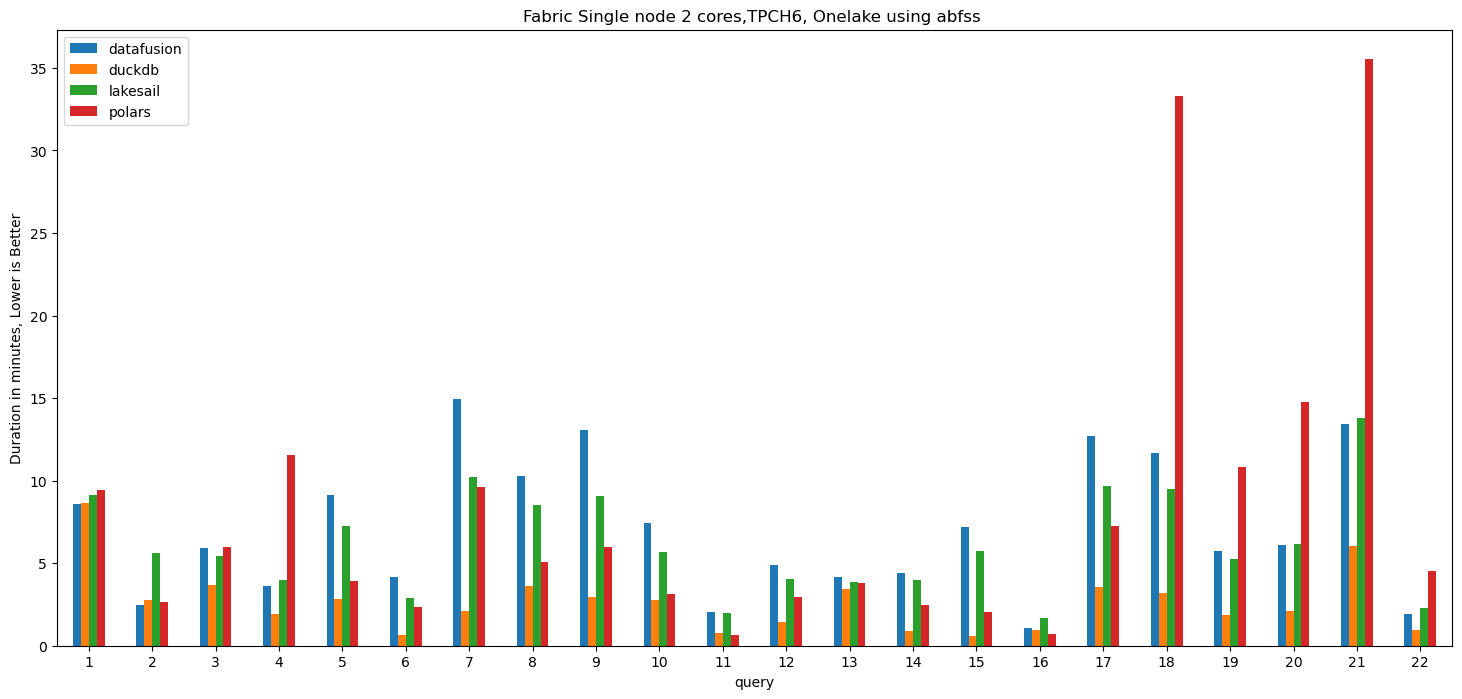

In [13]:
import duckdb
con = duckdb.connect()
raw = con.sql(f""" 
    select Engine,time, query, sf, cpu as core, dur
    from delta_scan('{results}')
    where test = 'tpch' and Engine in ('lakesail','duckdb','datafusion','polars') 
    and sf = {SF}
    and cpu = 2
    and time >'2026-02-05'
    """)
t=con.sql("""
    pivot (select Engine,query, avg(dur) as dur from raw where Engine in ('duckdb','datafusion','polars','lakesail') group by all) on Engine using avg(dur)  order by query
""").df()
ax =t.plot.bar(rot=0,x='query',title=f"Fabric Single node {core} cores,TPCH{SF}, Onelake using abfss ",ylabel='Duration in minutes, Lower is Better',figsize=(18,8))

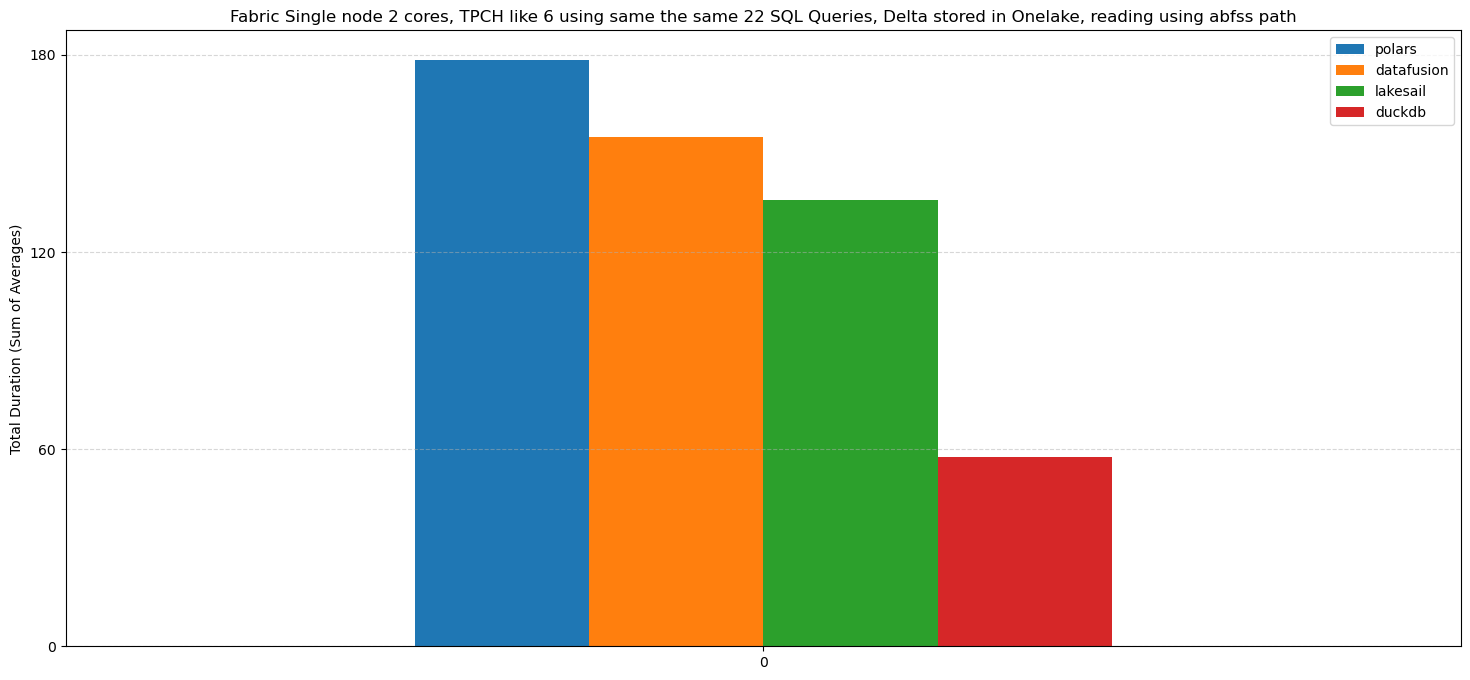

In [14]:
con.sql("""    CREATE OR REPLACE TEMP TABLE cc AS     SELECT Engine, query, AVG(dur) as dur     FROM raw     GROUP BY ALL """)

# 2. Pivot using SUM to get the total (Sum second)
# No 'GROUP BY' at the end ensures a single row result
s = con.sql("""  PIVOT (select *exclude(query) from cc) 
    ON Engine IN ( SELECT Engine FROM cc  GROUP BY Engine ORDER BY SUM(dur) DESC ) USING SUM(dur) """).df()
ax = s.plot.bar(
    rot=0,
    title=f"Fabric Single node {core} cores, TPCH like {SF} using same the same 22 SQL Queries, Delta stored in Onelake, reading using abfss path",
    ylabel='Total Duration (Sum of Averages)',
    figsize=(18,8)
)
ax.set_yticks([0, 60, 120, 180])
ax.grid(axis='y', linestyle='--', alpha=0.5)